In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [2]:
#### Load true and false flares data
# Load dataframes
true_flares_df = pd.read_csv('../Chandra_data/trueflares.csv')
false_flares_df = pd.read_csv('../Chandra_data/falseflares.csv')
true_flares_df = true_flares_df[['time','energy','obsreg_id']]
false_flares_df = false_flares_df[['time','energy','obsreg_id']]

# Convert to data dictionary
d = true_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict()
d.update(false_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict())

In [3]:
# Prepare for data, drop the outliers, 
data_lst = []
lengths = []
Ts = []
length_threshold = 5000
T_threshold = 250000
for key in list(d.keys()):
    length = len(d[key])
    T = max(d[key][:,0]) - min(d[key][:,0])
    if length > length_threshold or T > T_threshold:
        continue
    else:
        lengths.append(length)
        Ts.append(T)
        data_lst.append({'event_list':d[key]})

B = 64
data = RealEventsDataset(data_lst)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)
lengths = np.array(lengths)
Ts = np.array(Ts)

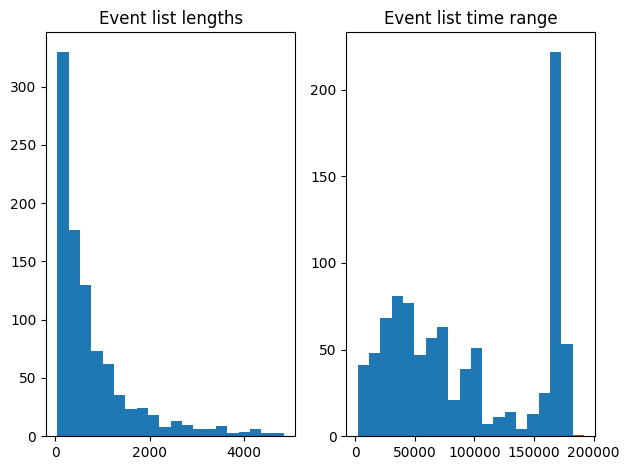

In [20]:
# Visualization
fig, ax = plt.subplots(1,2)
ax[0].hist(lengths,bins=20);
ax[0].set_title('Event list lengths')

ax[1].hist(Ts,bins=20);
ax[1].set_title('Event list time range')
plt.tight_layout()

In [25]:
# Create NN model
num_freqs = 12
num_latent = 20
E_bins = 13
encoding = PositionalEncoding(num_freqs=num_freqs)
# encoding = DiffEncoding(include_input=True)
model = AutoencoderRNN(num_latent, encoding, hidden_size=256, E_bins=E_bins, lam_TV=0, lam_latent=0)
trainer = pl.Trainer(max_epochs=5, 
                     accelerator=device, 
                     devices=1, 
                     plugins=[DisabledSLURMEnvironment(auto_requeue=False)], 
                     log_every_n_steps=2)
history = trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | code           | PositionalEncoding | 0     
1 | encoder_lstm   | LSTM               | 303 K 
2 | encoder_linear | Linear             | 5.1 K 
3 | decoder        | ResnetFC           | 28.7 K
------------------------------------------------------
336 K     Trainable params
0         Non-trainable params
336 K     Total params
1.348     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [26]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=64, collate_fn=padding_collate_fn)
test_batch = next(iter(test_loader))
model.eval();
model.to(device);
with torch.no_grad():
    model.encode(model.code(test_batch['event_list'].to(device)))
    z = model.latent.cpu().numpy()

In [27]:
# Visualize the rate function that the NN has learned.
with torch.no_grad():
    coded = model.code(test_batch['event_list'].to(device))
    rates = model.decode(coded[:,:,:-E_bins])
    coded = coded.cpu()
    rates = rates.cpu()

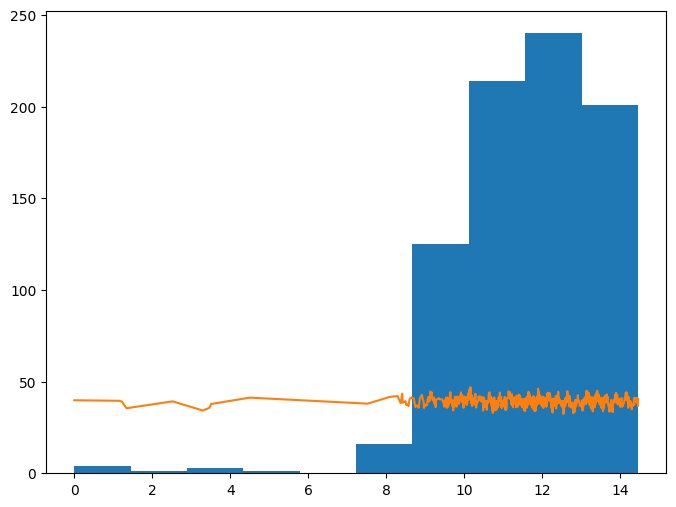

tensor(55.7031)


In [55]:
# Plot total rates
index = 25
masks = test_batch['mask']
plt.figure(figsize=(8,6))
plt.hist(coded[index,masks[index],0])
plt.plot(coded[index,masks[index],0], torch.sum(rates[index,masks[index],:],dim=-1))
plt.show()
temp = coded[index,masks[index],0]
print(len(temp)/temp.max())